# Initilalizing

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
'Colab Notebooks'/                       IncpetionModel1/
 Dataset/                                model.png
 FinalModel/                             S3CRET/
 Gabriele/                               SimpleLSTMForecasting/
 IncpetionFtAugModel1/                   SimplerModel/
 IncpetionFtAugWeighModel1/              StandardModel/
 IncpetionFtAugWeighModel1_more_layer/   training/
 IncpetionFtModel1/


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
# Normalize 
dataset_min = dataset.min()
dataset_max = dataset.max()
print(dataset_min)
print(dataset_max)
dataset_norm = (dataset-dataset_min)/(dataset_max-dataset_min)
dataset_norm.head()

Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


### Windowing 


In [ ]:
TELESCOPE = 864
WINDOWS_LENGTH = 4000 
VALIDATION_SPLIT = 0.2

In [ ]:
future = dataset_norm[-WINDOWS_LENGTH:]
future = np.expand_dims(future, axis=0)
future.shape

(1, 4000, 7)

In [ ]:
def build_sequences(df, target_labels, window=2000, stride=20, telescope=864): #1156/4 = 288 time-steps into the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
target_labels = dataset_norm.columns

In [ ]:
X_train, y_train = build_sequences(dataset_norm, target_labels, window =WINDOWS_LENGTH, telescope = TELESCOPE)
X_val = X_train[-math.floor(len(X_train)*VALIDATION_SPLIT):,:,:]
y_val = y_train[-math.floor(len(y_train)*VALIDATION_SPLIT):,:,:]
X_train = X_train[0:len(X_train)-math.floor(len(X_train)*VALIDATION_SPLIT), : , :] 
y_train = y_train[0:len(y_train)-math.floor(len(y_train)*VALIDATION_SPLIT), : , :]


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2686, 4000, 7), (2686, 864, 7), (671, 4000, 7), (671, 864, 7))

## RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=True), #more layer
    tf.keras.layers.LSTM(32, return_sequences=False), #more neurons
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([TELESCOPE, 7])
])

multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs= 200
batch_size = 64
history_6 = multi_lstm_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
42/42 [==============================] - 36s 763ms/step - loss: 0.0701 - mean_absolute_error: 0.1827 - root_mean_squared_error: 0.2647 - val_loss: 0.0185 - val_mean_absolute_error: 0.0995 - val_root_mean_squared_error: 0.1362 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 31s 738ms/step - loss: 0.0181 - mean_absolute_error: 0.0975 - root_mean_squared_error: 0.1347 - val_loss: 0.0187 - val_mean_absolute_error: 0.0990 - val_root_mean_squared_error: 0.1366 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - 31s 741ms/step - loss: 0.0179 - mean_absolute_error: 0.0969 - root_mean_squared_error: 0.1338 - val_loss: 0.0186 - val_mean_absolute_error: 0.0990 - val_root_mean_squared_error: 0.1366 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 31s 739ms/step - loss: 0.0179 - mean_absolute_error: 0.0969 - root_mean_squared_error: 0.1337 - val_loss: 0.0186 - val_mean_absolute_error: 0.0988 - val_root_mean_squared_error: 0.1365 - lr: 0.0

In [ ]:
#multi_lstm_model.save('SimpleLSTMForecasting')
multi_lstm_model = tfk.models.load_model('SimpleLSTMForecasting')

In [ ]:
# See prediction on the validation set
predictions = multi_lstm_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0109056765>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07831226>,
 0.10443024715742501)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        #axs[i].set_ylim(0,1)
    plt.show()

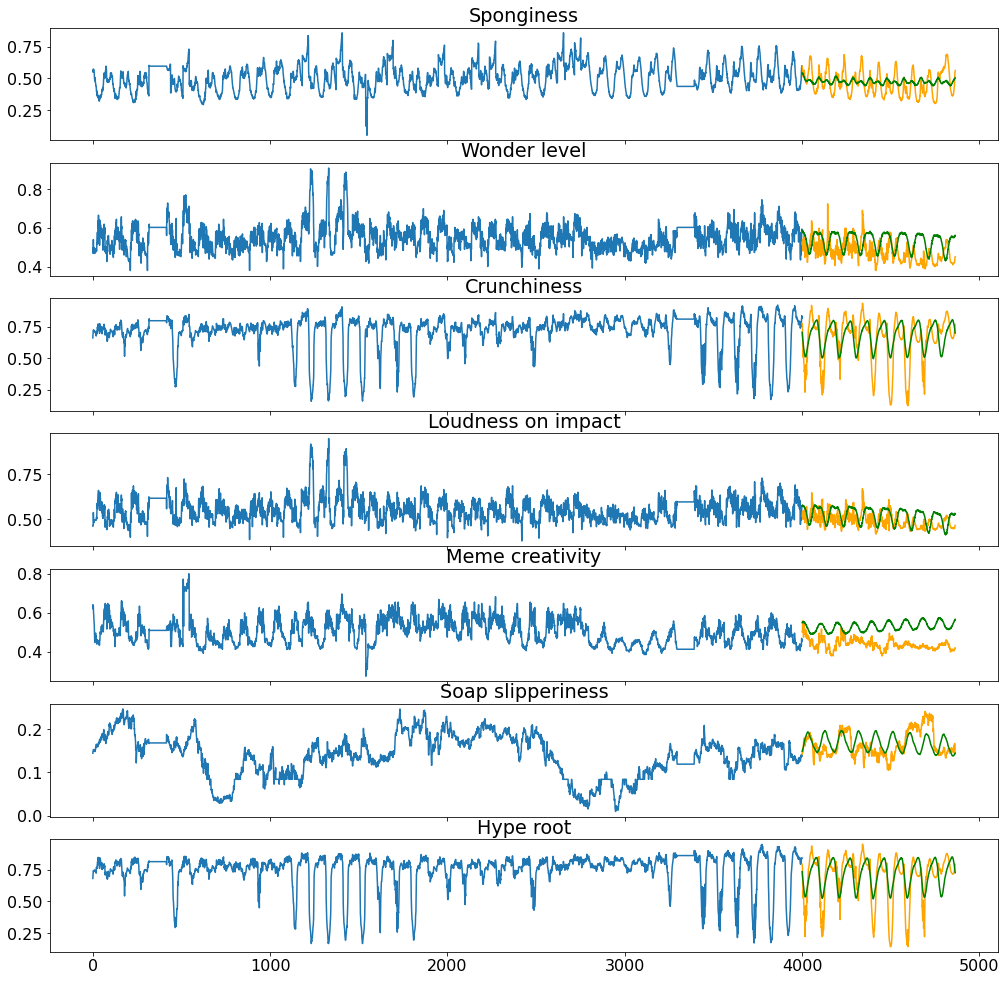

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

In [ ]:
X = np.array(dataset)

# Normalize 
X_min = X.min(axis=0)
X_max = X.max(axis=0)
print(X_min)
print(X_max)
X_norm = (X-X_min)/(X_max-X_min)
#X_norm.head()

# Scale up 
X_val_up = X_val*(X_max-X_min)+X_min
y_val_up = y_val*(X_max-X_min)+X_min

# See prediction on the validation set
predictions1 = multi_lstm_model.predict(X_val)
predictions_up = predictions1*(X_max-X_min)+X_min

mean_squared_error = tfk.metrics.mse(y_val_up.flatten(),predictions_up.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_up.flatten(),predictions_up.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

[ -0.97207994  -8.45037973 -37.58172096  -9.02805982  -1.27586009
  -6.00686032 -42.76922096]
[15.10668024 18.1228993  41.13880051 14.03598027  6.05636001 77.37161995
 31.02441982]


(<tf.Tensor: shape=(), dtype=float64, numpy=37.64366768446483>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.6233805188494754>,
 6.135443560531287)

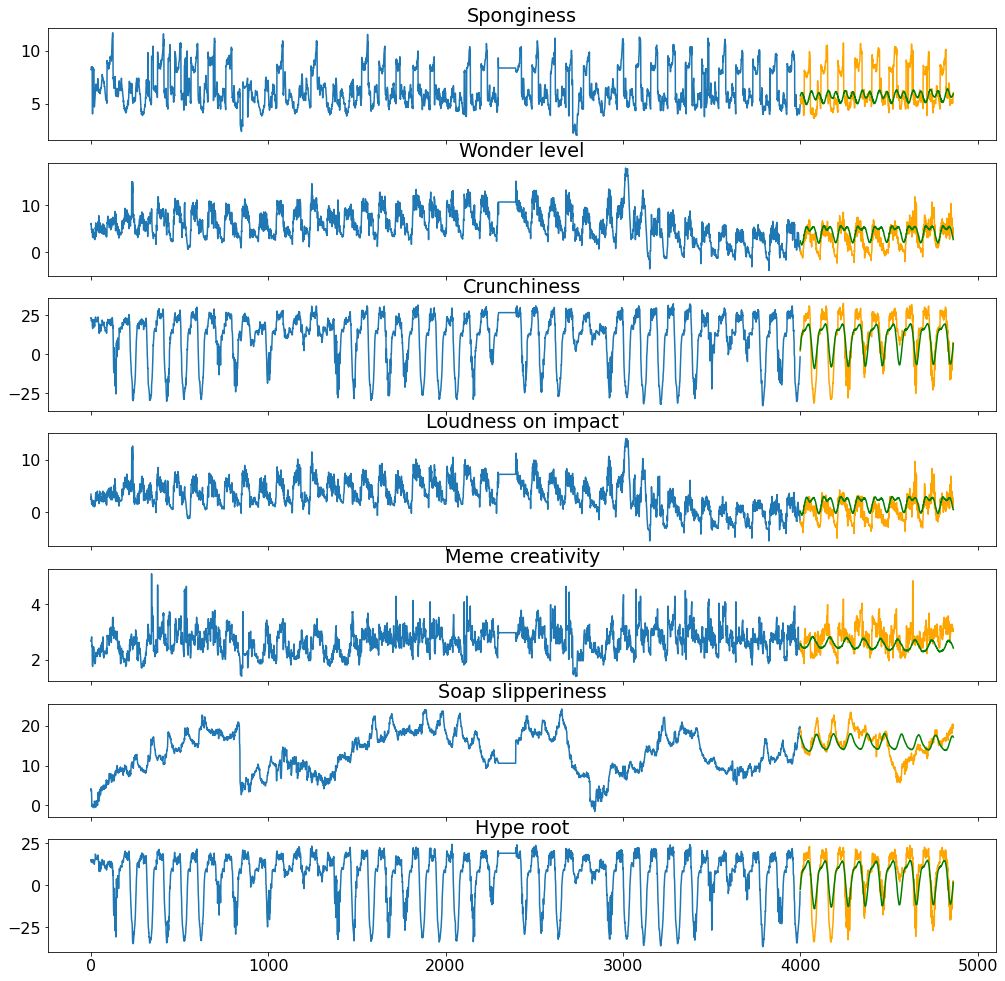

In [ ]:
inspect_multivariate_prediction(X_val_up, y_val_up, predictions_up, target_labels, TELESCOPE)

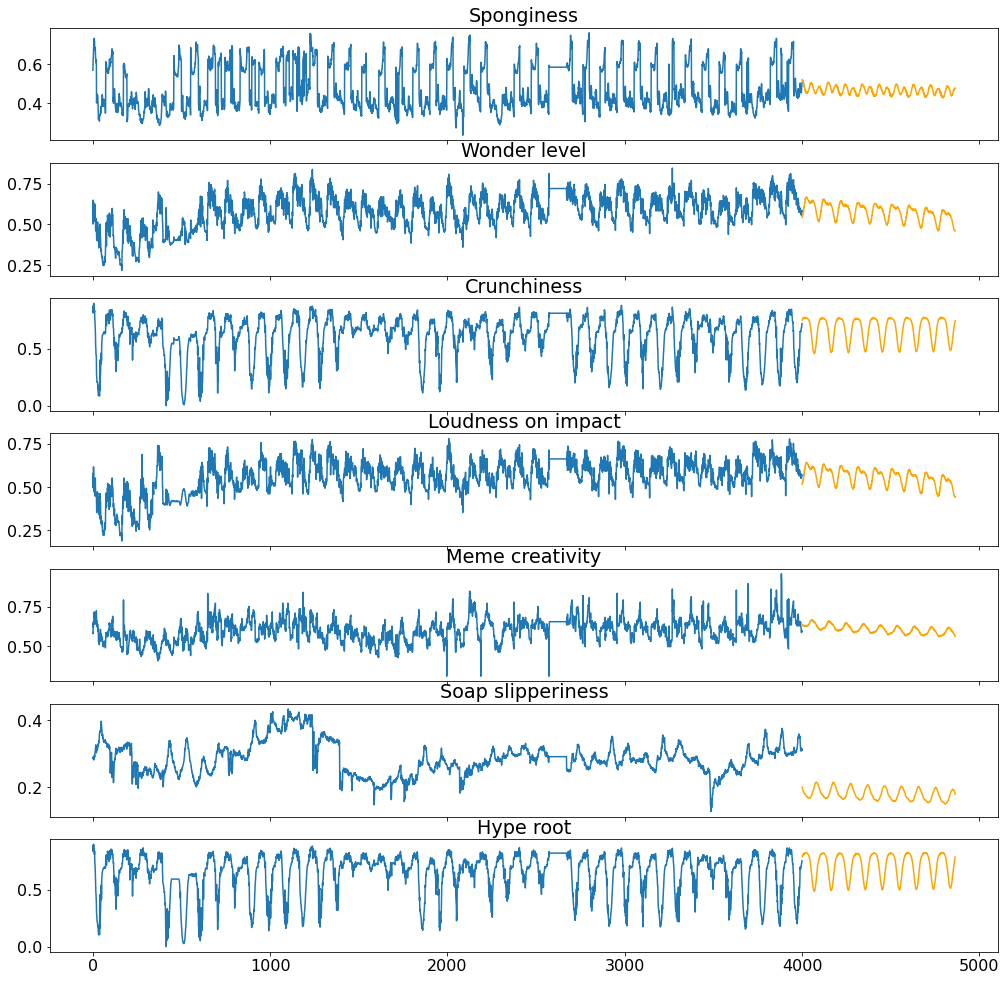

In [ ]:
# Predict the future 
future_predictions = multi_lstm_model.predict(future)
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+TELESCOPE), future_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
## Insert your preprocessing here
#multi_lstm_model = tfk.models.load_model('SimpleLSTMForecasting')
TELESCOPE = 864
WINDOWS_LENGTH = 2000

X = np.array(dataset)

# Normalize 
X_min = X.min(axis=0)
X_max = X.max(axis=0)
print(X_min)
print(X_max)
X_norm = (X-X_min)/(X_max-X_min)
#X_norm.head()

future = X_norm[-WINDOWS_LENGTH:]
future = np.expand_dims(future, axis=0)
future_up = future*(X_max-X_min)+X_min

## Predict
out_norm = multi_lstm_model.predict(future)

## Insert your postprocessing here TODO

# Denormalize
out = out_norm*(X_max-X_min)+X_min
out = out[0, :, :]
out = tf.convert_to_tensor(out, np.float32 )
out.shape


[ -0.97207994  -8.45037973 -37.58172096  -9.02805982  -1.27586009
  -6.00686032 -42.76922096]
[15.10668024 18.1228993  41.13880051 14.03598027  6.05636001 77.37161995
 31.02441982]


TensorShape([864, 7])

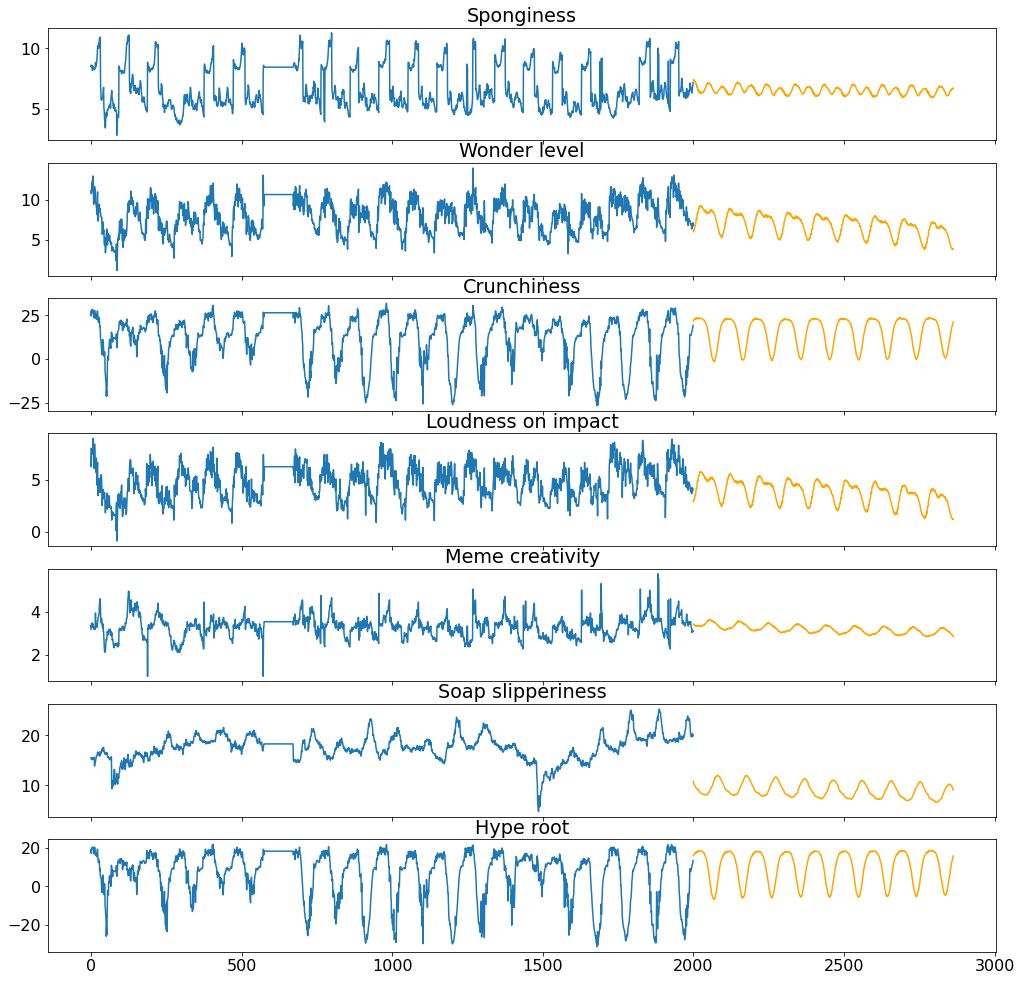

In [ ]:
## see if the future predicted is right
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future_up[0,:,i])), future_up[0,:,i])
    axs[i].plot(np.arange(len(future_up[0,:,i]), len(future_up[0,:,i])+TELESCOPE), out[:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()